In [ ]:
!unzip dataset_organizado.zip

Archive:  dataset_organizado.zip
   creating: dataset_organizado/
   creating: dataset_organizado/test/
   creating: dataset_organizado/test/Ceda el paso/
  inflating: dataset_organizado/test/Ceda el paso/images (69).jpeg  
  inflating: dataset_organizado/test/Ceda el paso/images (70).jpeg  
  inflating: dataset_organizado/test/Ceda el paso/images (71).jpeg  
  inflating: dataset_organizado/test/Ceda el paso/images (72).jpeg  
  inflating: dataset_organizado/test/Ceda el paso/images (73).jpeg  
  inflating: dataset_organizado/test/Ceda el paso/images (74).jpeg  
  inflating: dataset_organizado/test/Ceda el paso/images (75).jpeg  
  inflating: dataset_organizado/test/Ceda el paso/images (76).jpeg  
  inflating: dataset_organizado/test/Ceda el paso/images (77).jpeg  
  inflating: dataset_organizado/test/Ceda el paso/images (78).jpeg  
  inflating: dataset_organizado/test/Ceda el paso/images (79).jpeg  
  inflating: dataset_organizado/test/Ceda el paso/images (80).jpeg  
  inflating: data

In [ ]:
import os
import shutil
from pathlib import Path
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np

# ================= CONFIGURACIÓN =================

DIR_ENTRADA = Path("dataset_organizado")
DIR_SALIDA = Path("dataset_sin_rotacion_variado")

CONFIG = {
    # 1. ZOOM: Valores > 1.0 acercan la imagen.
    # 1.1 = 10% de zoom, 1.2 = 20% de zoom
    "zoom": [1.1, 1.2],

    # 2. BRILLO: Oscuro y Claro
    "brillo": [0.7, 1.3],

    # 3. CONTRASTE: Bajo y Alto
    "contraste": [0.8, 1.5],

    # 4. DESENFOQUE: True para aplicar un leve borrosidad
    "aplicar_desenfoque": True,

    # 5. RUIDO: True para agregar "grano" a la imagen
    "aplicar_ruido": True,

    "extensiones": ['.png', '.jpg', '.jpeg', '.bmp', '.webp'],
    "calidad_jpg": 100
}

# ================= HERRAMIENTAS DE AUMENTACIÓN =================

def guardar_imagen_hd(img, ruta):
    try:
        if img.mode != 'RGB': img = img.convert('RGB')
        img.save(ruta, 'JPEG', quality=CONFIG["calidad_jpg"], subsampling=0)
    except Exception as e:
        print(f"Error guardando {ruta.name}: {e}")

def aplicar_zoom_central(img, factor):
    """Recorta el centro y lo redimensiona al tamaño original (Zoom In)"""
    w, h = img.size
    x_center, y_center = w / 2, h / 2

    # Calcular el tamaño del recorte
    new_w = w / factor
    new_h = h / factor

    left = x_center - (new_w / 2)
    top = y_center - (new_h / 2)
    right = x_center + (new_w / 2)
    bottom = y_center + (new_h / 2)

    img_cropped = img.crop((left, top, right, bottom))
    # Volver al tamaño original con filtro de alta calidad (LANCZOS)
    return img_cropped.resize((w, h), Image.Resampling.LANCZOS)

def agregar_ruido_gaussiano(img):
    """Agrega granulado a la imagen"""
    # Convertir a array numpy
    img_array = np.array(img)

    # Generar ruido
    mean = 0
    std = 15 # Intensidad del ruido (ajustable)
    noise = np.random.normal(mean, std, img_array.shape).astype('uint8')

    # Sumar ruido a la imagen original (cuidando no pasar de 255)
    img_noise = Image.fromarray(np.clip(img_array + noise, 0, 255).astype('uint8'))
    return img_noise

# ================= PROCESO PRINCIPAL =================

def procesar_train():
    input_train = DIR_ENTRADA / "train"
    output_train = DIR_SALIDA / "train"

    if not input_train.exists():
        print(f"❌ ERROR: No encuentro {input_train}")
        return

    print(f"🚀 PROCESANDO 'TRAIN' (Zoom, Ruido, Desenfoque, Contraste)...")

    for categoria_path in input_train.iterdir():
        if not categoria_path.is_dir(): continue

        output_cat = output_train / categoria_path.name
        output_cat.mkdir(parents=True, exist_ok=True)

        imagenes = [f for f in categoria_path.glob('*') if f.suffix.lower() in CONFIG["extensiones"]]
        print(f"   📂 {categoria_path.name}: Generando variaciones de {len(imagenes)} imágenes...")

        for archivo in imagenes:
            try:
                img = Image.open(archivo).convert('RGB')
                nombre = archivo.stem

                # 1. Guardar ORIGINAL
                guardar_imagen_hd(img, output_cat / f"{nombre}_original.jpg")

                # 2. Variaciones de ZOOM
                for z in CONFIG["zoom"]:
                    img_zoom = aplicar_zoom_central(img, z)
                    guardar_imagen_hd(img_zoom, output_cat / f"{nombre}_zoom{int(z*100)}.jpg")

                # 3. Variaciones de BRILLO
                for b in CONFIG["brillo"]:
                    enhancer = ImageEnhance.Brightness(img)
                    img_b = enhancer.enhance(b)
                    guardar_imagen_hd(img_b, output_cat / f"{nombre}_brillo{int(b*100)}.jpg")

                # 4. Variaciones de CONTRASTE
                for c in CONFIG["contraste"]:
                    enhancer = ImageEnhance.Contrast(img)
                    img_c = enhancer.enhance(c)
                    guardar_imagen_hd(img_c, output_cat / f"{nombre}_contraste{int(c*100)}.jpg")

                # 5. Variación de DESENFOQUE (Blur)
                if CONFIG["aplicar_desenfoque"]:
                    # Radius 2 es un desenfoque suave
                    img_blur = img.filter(ImageFilter.GaussianBlur(radius=2))
                    guardar_imagen_hd(img_blur, output_cat / f"{nombre}_blur.jpg")

                # 6. Variación de RUIDO
                if CONFIG["aplicar_ruido"]:
                    img_ruido = agregar_ruido_gaussiano(img)
                    guardar_imagen_hd(img_ruido, output_cat / f"{nombre}_ruido.jpg")

            except Exception as e:
                print(f"   Error en {archivo.name}: {e}")

def copiar_test():
    input_test = DIR_ENTRADA / "test"
    output_test = DIR_SALIDA / "test"
    if input_test.exists():
        if output_test.exists(): shutil.rmtree(output_test)
        shutil.copytree(input_test, output_test)
        print("\n📦 Carpeta TEST copiada (sin cambios).")

if __name__ == "__main__":
    if DIR_SALIDA.exists(): shutil.rmtree(DIR_SALIDA)
    DIR_SALIDA.mkdir()

    procesar_train()
    copiar_test()

    print("\n" + "="*60)
    print(f"✅ ¡LISTO! Dataset guardado en: {DIR_SALIDA}")
    print("="*60)
    print("Ejecuta el zip para descargar.")

🚀 PROCESANDO 'TRAIN' (Zoom, Ruido, Desenfoque, Contraste)...
   📂 Semaforo: Generando variaciones de 80 imágenes...
   📂 Ceda el paso: Generando variaciones de 80 imágenes...
   📂 Pare: Generando variaciones de 80 imágenes...

📦 Carpeta TEST copiada (sin cambios).

✅ ¡LISTO! Dataset guardado en: dataset_sin_rotacion_variado
Ejecuta el zip para descargar.


In [ ]:
# Comprimir la carpeta exacta que generamos en el paso anterior
# (El nombre debe coincidir con DIR_SALIDA del script anterior)
!zip -r dataset_final.zip dataset_sin_rotacion_variado

print("✅ Compresión terminada.")
print("⬇️ Iniciando descarga...")



  adding: dataset_sin_rotacion_variado/ (stored 0%)
  adding: dataset_sin_rotacion_variado/train/ (stored 0%)
  adding: dataset_sin_rotacion_variado/train/Semaforo/ (stored 0%)
  adding: dataset_sin_rotacion_variado/train/Semaforo/images (70)_brillo70.jpg (deflated 3%)
  adding: dataset_sin_rotacion_variado/train/Semaforo/images (78)_zoom120.jpg (deflated 1%)
  adding: dataset_sin_rotacion_variado/train/Semaforo/images (74)_contraste150.jpg (deflated 4%)
  adding: dataset_sin_rotacion_variado/train/Semaforo/images (71)_brillo130.jpg (deflated 1%)
  adding: dataset_sin_rotacion_variado/train/Semaforo/images (74)_brillo130.jpg (deflated 4%)
  adding: dataset_sin_rotacion_variado/train/Semaforo/images (88)_blur.jpg (deflated 2%)
  adding: dataset_sin_rotacion_variado/train/Semaforo/images (28)_original.jpg (deflated 3%)
  adding: dataset_sin_rotacion_variado/train/Semaforo/images (26)_zoom120.jpg (deflated 1%)
  adding: dataset_sin_rotacion_variado/train/Semaforo/images (89)_blur.jpg (def

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Modelo 'keras_model.h5' cargado exitosamente.
✅ Etiquetas de Modelo (TM Order): ['Semaforo', 'Ceda el paso', 'Pare']
Found 60 images belonging to 3 classes.
✅ Etiquetas de Generador (Alphabetic Order): ['Ceda el paso', 'Pare', 'Semaforo']
✅ Vector de Mapeo de Índices (TM -> Generador): [2, 0, 1]

--- 1. Generando Predicciones Detalladas ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step



--- 2. Matriz de Confusión ---
[[17  3  0]
 [ 1 18  1]
 [ 1  1 18]]


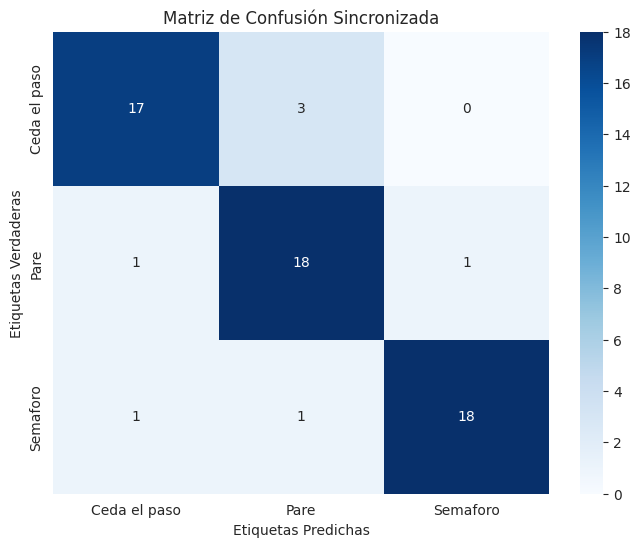


--- 3. Reporte de Clasificación (Métricas Formales) ---
              precision    recall  f1-score   support

Ceda el paso       0.89      0.85      0.87        20
        Pare       0.82      0.90      0.86        20
    Semaforo       0.95      0.90      0.92        20

    accuracy                           0.88        60
   macro avg       0.89      0.88      0.88        60
weighted avg       0.89      0.88      0.88        60



In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ==================== FIX CRÍTICO PARA TEACHABLE MACHINE (Mismo que antes) ====================
class FixedDepthwiseConv2D(tf.keras.layers.DepthwiseConv2D):
    def __init__(self, **kwargs):
        if 'groups' in kwargs:
            del kwargs['groups']
        super().__init__(**kwargs)

# ==================== CONFIGURACIÓN ====================
RUTA_TEST = 'dataset_organizado/test'
NOMBRE_MODELO = 'keras_model.h5' # Tu archivo del modelo
NOMBRE_LABELS = 'labels.txt'     # Tu archivo de etiquetas
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32

# ==================== PASO A: CARGAR EL MODELO ====================
try:
    model = tf.keras.models.load_model(
        NOMBRE_MODELO,
        custom_objects={'DepthwiseConv2D': FixedDepthwiseConv2D},
        compile=False
    )
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(f"✅ Modelo '{NOMBRE_MODELO}' cargado exitosamente.")
except Exception as e:
    print(f"❌ ERROR CRÍTICO: No se pudo cargar el modelo. Verifica la ruta de '{NOMBRE_MODELO}'.")
    exit()

# ==================== PASO B: CARGAR Y AJUSTAR ETIQUETAS ====================

# 1. Leer las etiquetas en el ORDEN DEL MODELO (Desde labels.txt)
try:
    with open(NOMBRE_LABELS, 'r') as f:
        # Quitamos los números y espacios, solo nombres de clase
        model_classes = [line.strip().split(' ', 1)[-1] for line in f if line.strip()]
    print(f"✅ Etiquetas de Modelo (TM Order): {model_classes}")
except Exception as e:
    print(f"❌ ERROR: No se pudo leer el archivo '{NOMBRE_LABELS}'. Asegúrate de que existe.")
    exit()

# 2. Preparar el generador de datos
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    RUTA_TEST,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# 3. Mapeo de índices: Obtener el orden ALFABÉTICO del generador
generator_classes = list(test_generator.class_indices.keys())

# 4. Crear el vector de mapeo: Dónde está la clase del modelo en el generador
#    Ej: Si TM_Order=[Semáforo, Pare] y Gen_Order=[Pare, Semáforo]
#    El mapeo dirá: [1, 0] (La clase 0 de TM es la clase 1 del generador, etc.)
index_map = [generator_classes.index(cls) for cls in model_classes]

print(f"✅ Etiquetas de Generador (Alphabetic Order): {generator_classes}")
print(f"✅ Vector de Mapeo de Índices (TM -> Generador): {index_map}")

# ==================== PASO C: EVALUACIÓN FORMAL ====================

# 1. Obtener las etiquetas verdaderas y predicciones
print("\n--- 1. Generando Predicciones Detalladas ---")
Y_pred = model.predict(test_generator, steps=len(test_generator))
# Convertir las probabilidades a las clases ORIGINALES DEL MODELO (0, 1, 2...)
y_pred_model_indices = np.argmax(Y_pred, axis=1)

# 2. Re-ordenar las predicciones para que coincidan con el generador
#    Usamos el vector de mapeo para convertir los índices del modelo a los índices del generador
y_pred_aligned_indices = np.array([index_map[i] for i in y_pred_model_indices])

# Las etiquetas verdaderas (y_true) ya están en el orden del generador
y_true = test_generator.classes

# 3. Matriz de Confusión y Reporte (AHORA SÍ ALINEADOS)
print("\n--- 2. Matriz de Confusión ---")
conf_matrix = confusion_matrix(y_true, y_pred_aligned_indices)
print(conf_matrix)

# 4. Visualizar la Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=generator_classes, yticklabels=generator_classes)
plt.title('Matriz de Confusión Sincronizada')
plt.ylabel('Etiquetas Verdaderas')
plt.xlabel('Etiquetas Predichas')
plt.show()

# 5. Reporte de Clasificación (Métricas Formales)
print("\n--- 3. Reporte de Clasificación (Métricas Formales) ---")
reporte = classification_report(y_true, y_pred_aligned_indices, target_names=generator_classes)
print(reporte)

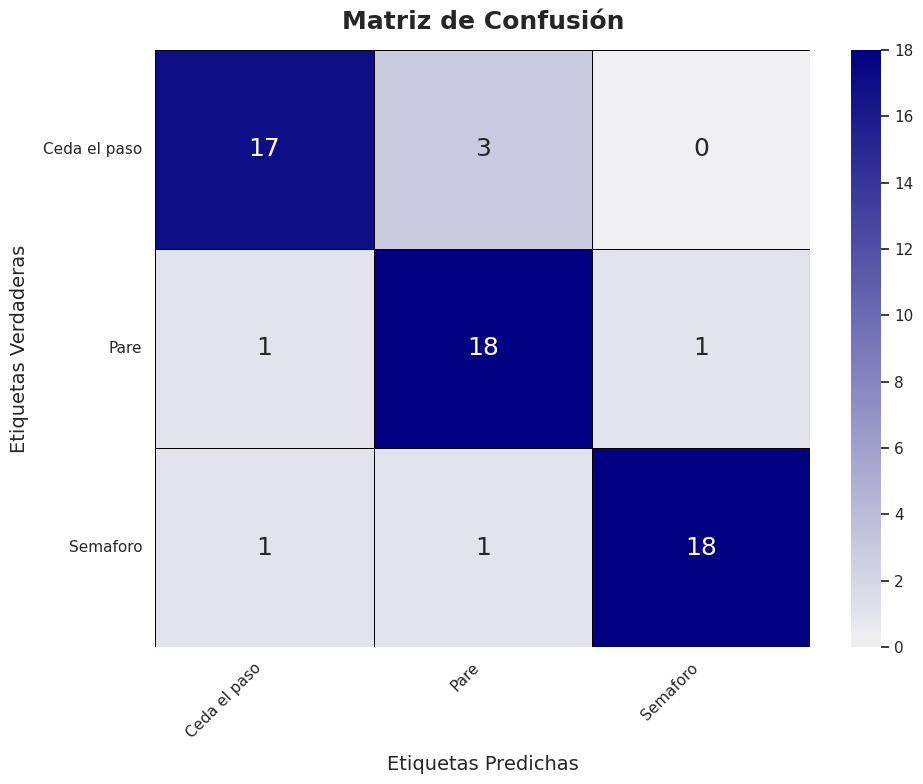

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- CONFIGURACIÓN DE VISUALIZACIÓN ---
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Arial'

# Mapa de color (manteniendo el tono profesional)
cmap = sns.light_palette("navy", as_cmap=True)

# --- CREACIÓN DE LA MATRIZ (CON NÚMEROS MÁS GRANDES) ---
sns.heatmap(
    conf_matrix,
    annot=True,               # Mostrar los números dentro de los cuadros
    fmt='d',                  # Formato: Entero
    cmap=cmap,                # Aplicar el mapa de color profesional
    linewidths=0.5,
    linecolor='black',
    cbar=True,
    xticklabels=generator_classes,
    yticklabels=generator_classes,
    annot_kws={"fontsize": 18}  # <--- ¡CAMBIO CLAVE: Aumenta el tamaño del texto!
)

# --- AJUSTES ESTÉTICOS FINALES ---
plt.title('Matriz de Confusión', fontsize=18, fontweight='bold', pad=15)
plt.ylabel('Etiquetas Verdaderas', fontsize=14, labelpad=10)
plt.xlabel('Etiquetas Predichas', fontsize=14, labelpad=10)

plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Guardar la figura con alta resolución
plt.savefig('Matriz_Poster_Final_HD.png', dpi=300, bbox_inches='tight')
plt.show()

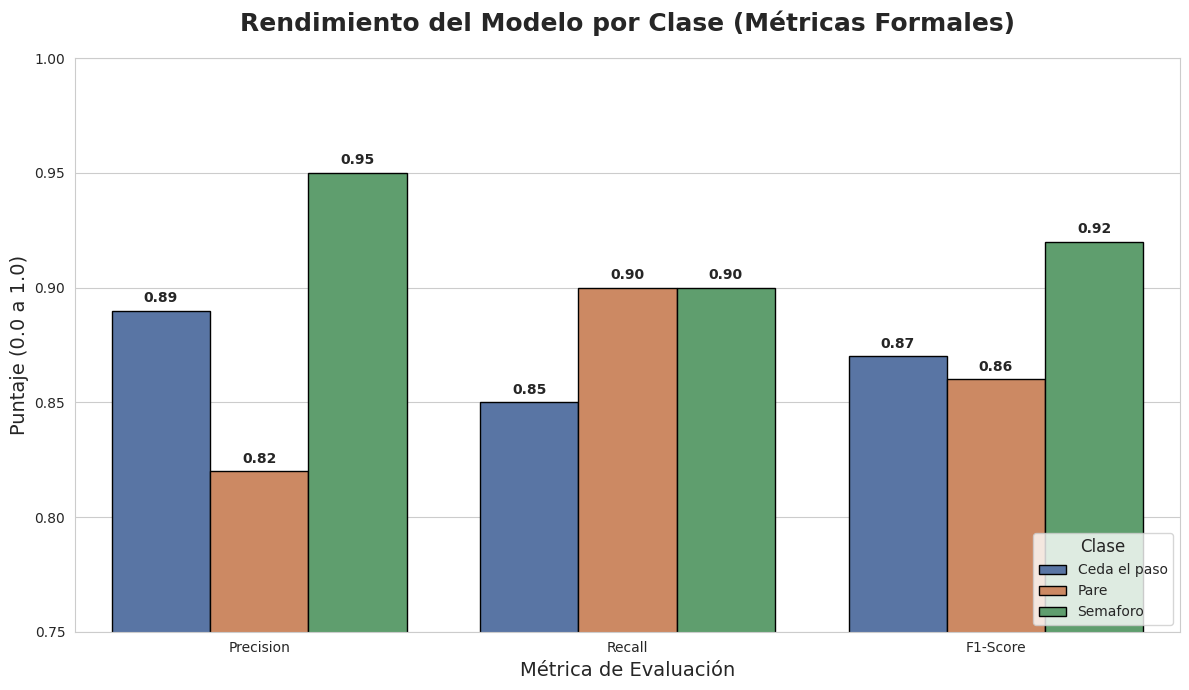

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. DATOS DE ENTRADA (Extraídos de tu imagen)
data = {
    'Clase': ['Ceda el paso', 'Pare', 'Semaforo', 'Ceda el paso', 'Pare', 'Semaforo', 'Ceda el paso', 'Pare', 'Semaforo'],
    'Métrica': ['Precision', 'Precision', 'Precision',
                'Recall', 'Recall', 'Recall',
                'F1-Score', 'F1-Score', 'F1-Score'],
    'Puntaje': [0.89, 0.82, 0.95,
                0.85, 0.90, 0.90,
                0.87, 0.86, 0.92]
}

df_metrics = pd.DataFrame(data)

# 2. CONFIGURACIÓN DEL GRÁFICO (Ajustes Estéticos para Póster)
plt.figure(figsize=(12, 7)) # Tamaño más ancho y grande
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Arial'

# Definimos una paleta de colores (opciones profesionales: 'viridis', 'cividis', 'Set2')
palette = "deep"

# 3. CREACIÓN DEL GRÁFICO DE BARRAS AGRUPADAS
ax = sns.barplot(
    x='Métrica',
    y='Puntaje',
    hue='Clase',
    data=df_metrics,
    palette=palette,
    edgecolor='black' # Bordes negros para separar las barras
)

# 4. AJUSTES FINALES Y ETIQUETAS
plt.title('Rendimiento del Modelo por Clase (Métricas Formales)', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Puntaje (0.0 a 1.0)', fontsize=14)
plt.xlabel('Métrica de Evaluación', fontsize=14)
plt.ylim(0.75, 1.0) # Ajustar el eje Y para que la diferencia entre las barras sea más visible
plt.legend(title='Clase', fontsize=10, title_fontsize=12, loc='lower right')

# 5. AÑADIR ETIQUETAS DE DATOS (Crucial para un póster)
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.2f'),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha = 'center',
        va = 'center',
        xytext = (0, 9),
        textcoords = 'offset points',
        fontsize=10,
        fontweight='bold'
    )

plt.tight_layout()

# Guardar la figura con alta resolución (300 DPI)
plt.savefig('Grafico_Metricas_Formales_Poster.png', dpi=300, bbox_inches='tight')
plt.show()

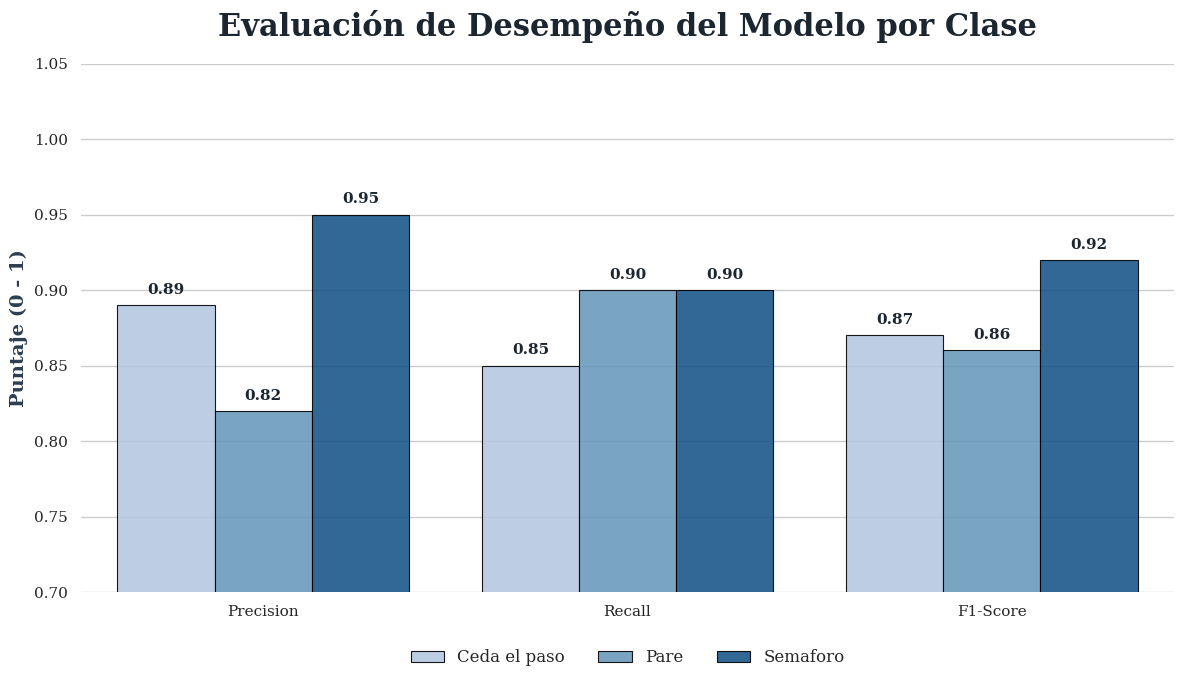

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. DATOS (Los mismos de tu reporte)
data = {
    'Clase': ['Ceda el paso', 'Pare', 'Semaforo'] * 3,
    'Métrica': ['Precision', 'Precision', 'Precision',
                'Recall', 'Recall', 'Recall',
                'F1-Score', 'F1-Score', 'F1-Score'],
    'Puntaje': [0.89, 0.82, 0.95,  # Precision
                0.85, 0.90, 0.90,  # Recall
                0.87, 0.86, 0.92]  # F1-Score
}
df_metrics = pd.DataFrame(data)

# 2. CONFIGURACIÓN ESTÉTICA AVANZADA
plt.figure(figsize=(12, 7))

# Estilo limpio con grid suave horizontal
sns.set_theme(style="whitegrid", font="serif") # 'serif' le da el toque académico clásico

# Paleta de Azules Profesionales (Secuencial pero distintiva)
# Color 1 (Claro): Ceda el paso | Color 2 (Medio): Pare | Color 3 (Oscuro): Semáforo
professional_blues = ["#AEC7E8", "#5D9ECB", "#08589E"]

# 3. CREACIÓN DEL GRÁFICO
ax = sns.barplot(
    x='Métrica',
    y='Puntaje',
    hue='Clase',
    data=df_metrics,
    palette=professional_blues,
    edgecolor='black',  # Borde negro fino para definición
    linewidth=0.8,      # Grosor del borde elegante
    alpha=0.9           # Ligera transparencia para suavizar
)

# 4. PERSONALIZACIÓN "PRO"
# Título formal y ejes
plt.title('Evaluación de Desempeño del Modelo por Clase', fontsize=22, fontweight='bold', pad=20, color='#1B2631')
plt.ylabel('Puntaje (0 - 1)', fontsize=14, fontweight='bold', color='#2C3E50')
plt.xlabel('') # Quitamos la etiqueta X porque "Precision/Recall" ya es obvio

# Ajustar eje Y para resaltar diferencias (Zoom en la parte superior)
plt.ylim(0.70, 1.05)

# Leyenda Minimalista en la parte inferior (para no tapar datos)
plt.legend(title='', fontsize=12, loc='upper center',
           bbox_to_anchor=(0.5, -0.08), ncol=3, frameon=False)

# 5. ETIQUETAS DE VALOR (ANNOTATIONS)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{height:.2f}',
        (p.get_x() + p.get_width() / 2., height),
        ha='center', va='bottom',
        xytext=(0, 6),
        textcoords='offset points',
        fontsize=11,
        fontweight='bold',
        color='#1B2631'
    )

# Limpiar bordes del gráfico (Estilo Tufte minimalista)
sns.despine(left=True, bottom=True)

plt.tight_layout()

# Guardar en Alta Resolución (300 DPI es estándar para impresión)
plt.savefig('Grafico_Cientifico_Azul.png', dpi=300, bbox_inches='tight')
plt.show()